In [1]:
import pyvista as pv
from skimage import filters, data
import numpy as np


interactive(children=(IntSlider(value=29, description='index', max=59), RadioButtons(description='along', opti…

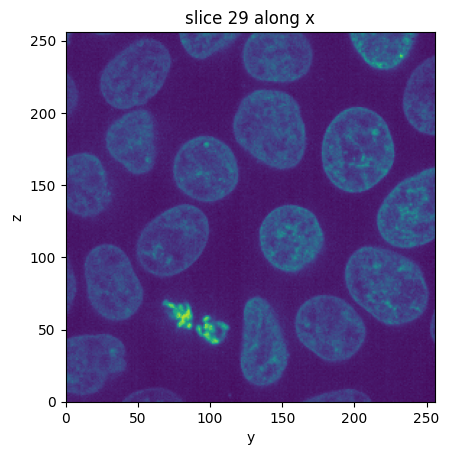

In [2]:
from nanomesh import Image
import numpy as np

from skimage.data import cells3d

data = cells3d()[:, 1, :, :]

vol = Image(data)

# swap axes so depth matches z
vol = vol.apply(np.swapaxes, axis1=0, axis2=2)

vol.show_slice()

interactive(children=(IntSlider(value=29, description='index', max=59), RadioButtons(description='along', opti…

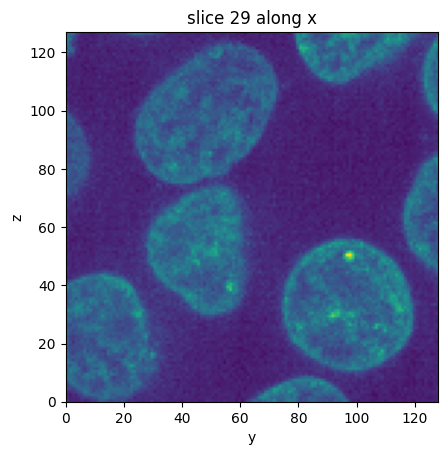

In [3]:
from skimage.transform import rescale

subvol = vol.select_subvolume(
    ys=(0, 128),
    zs=(128, -1),
)
subvol.show_slice()


interactive(children=(IntSlider(value=29, description='index', max=59), RadioButtons(description='along', opti…

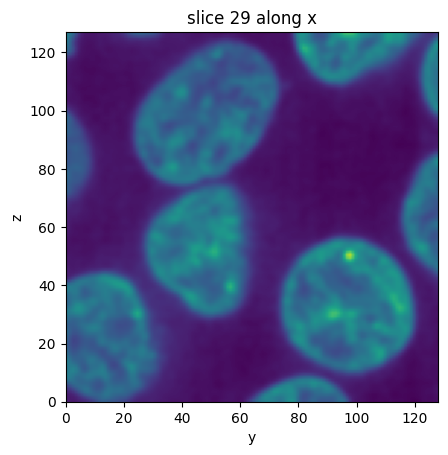

In [4]:
subvol_gauss = subvol.gaussian(sigma=1)
subvol_gauss.show_slice()

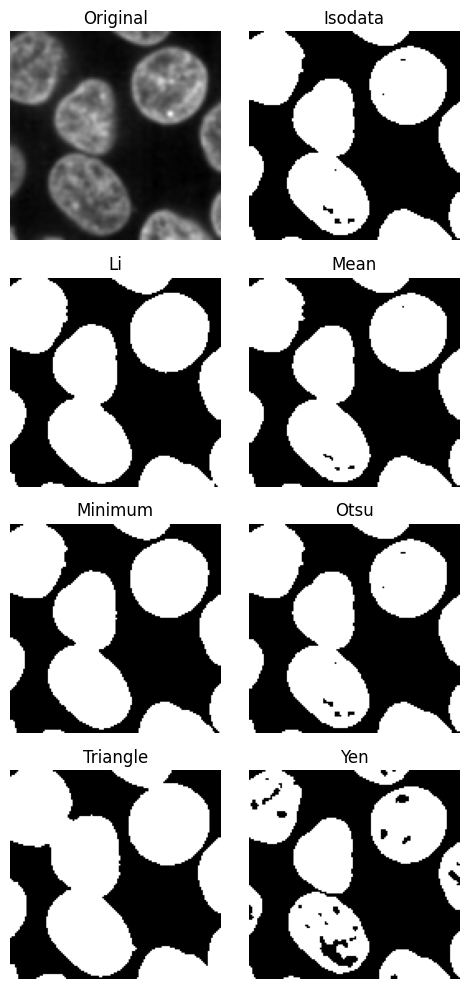

In [5]:
from skimage import filters

plane = subvol_gauss.select_plane(x=30)
plane.try_all_threshold(figsize=(5, 10))

interactive(children=(IntSlider(value=29, description='index', max=59), RadioButtons(description='along', opti…

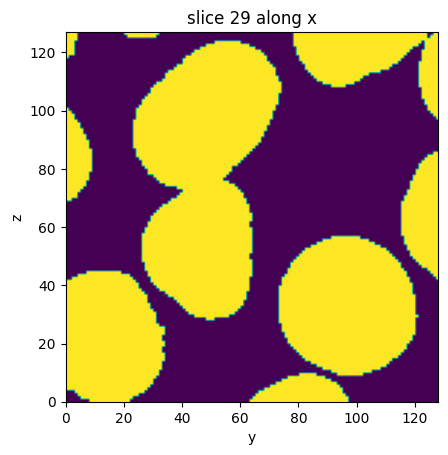

In [6]:
subvol_seg = subvol_gauss.binary_digitize(threshold='yen')
subvol_seg.show_slice()

interactive(children=(IntSlider(value=29, description='index', max=59), RadioButtons(description='along', opti…

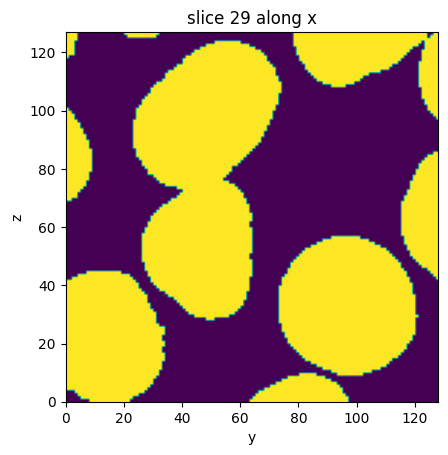

In [7]:
from scipy import ndimage


def fill_holes(image):
    return ndimage.binary_fill_holes(image).astype(int)


subvol_seg = subvol_seg.apply(fill_holes)
subvol_seg.show_slice()

In [8]:

from nanomesh import Mesher

mesher = Mesher(subvol_seg)
mesher.generate_contour()

mesh = mesher.tetrahedralize(opts='-pAq')


In [9]:
mesher.contour.region_markers

RegionMarkerList(
    RegionMarker(label=1, point=(44, 76, 48), name='background', constraint=0),
    RegionMarker(label=2, point=(47, 46, 33), name='X', constraint=0),
    RegionMarker(label=2, point=(2, 77, 38), name='X', constraint=0),
    RegionMarker(label=2, point=(0, 90, 50), name='X', constraint=0),
    RegionMarker(label=2, point=(31, 98, 34), name='X', constraint=0),
    RegionMarker(label=2, point=(9, 59, 46), name='X', constraint=0),
    RegionMarker(label=2, point=(15, 76, 48), name='X', constraint=0),
    RegionMarker(label=2, point=(23, 69, 51), name='X', constraint=0),
    RegionMarker(label=2, point=(69, 123, 35), name='X', constraint=0),
    RegionMarker(label=2, point=(43, 31, 59), name='X', constraint=0),
    RegionMarker(label=2, point=(48, 50, 59), name='X', constraint=0),
    RegionMarker(label=2, point=(51.15384615384615, 1.6153846153846154, 50.23076923076923), name='X', constraint=0),
    RegionMarker(label=2, point=(87, 6, 38), name='X', constraint=0),
    Reg

In [10]:
from nanomesh import metrics
tetra_mesh = mesh.get('tetra')

metrics_dict = metrics.calculate_all_metrics(tetra_mesh, inplace=True)
metrics_dict

{'area': array([-1., -1., -1., ..., -1., -1., -1.]),
 'aspect_frobenius': array([1.15627298, 1.19961119, 1.52280446, ..., 1.17937484, 1.12510482,
        1.70140423]),
 'aspect_ratio': array([1.42930625, 1.44666044, 1.85570124, ..., 1.44664648, 1.31368465,
        2.40649839]),
 'condition': array([1.16596618, 1.23247744, 1.49933901, ..., 1.16865821, 1.12170223,
        1.59278908]),
 'max_angle': array([-1., -1., -1., ..., -1., -1., -1.]),
 'min_angle': array([57.7009659 , 45.8899359 , 57.30776025, ..., 68.54450892,
        44.43336934, 55.34695463]),
 'radius_ratio': array([1.25544786, 1.35904953, 1.54553959, ..., 1.2505475 , 1.13137389,
        2.42175233]),
 'scaled_jacobian': array([0.60962613, 0.6435683 , 0.27677488, ..., 0.62849406, 0.68526511,
        0.34056193]),
 'shape': array([0.86484768, 0.83360343, 0.65668313, ..., 0.84790685, 0.88880608,
        0.5877498 ]),
 'relative_size_squared': array([0., 0., 0., ..., 0., 0., 0.]),
 'shape_and_size': array([0., 0., 0., ..., 0., 0

In [12]:
tetra_mesh.write('cells.vtk')

In [26]:
import meshio
mesh_from_file = meshio.read("cells.vtk")


array([2, 1, 1, ..., 2, 2, 1])

In [38]:
def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("tetgen-ref", cell_type)
    points = mesh.points[:, :2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={
                           "name_to_read": [cell_data]})
    return out_mesh
tetra_meshdX = create_mesh(mesh_from_file, "tetra", prune_z=False)
meshio.write("meshFolder/mesh.xdmf", tetra_meshdX)

In [37]:
!mkdir meshFolder

In [19]:
try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh
!git clone https://github.com/libigl/tetgen.git
!cd /content/tetgen && make
!cp /content/tetgen/tetgen /usr/local/bin

Cloning into 'tetgen'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 37 (delta 1), reused 3 (delta 0), pack-reused 27
Receiving objects: 100% (37/37), 608.51 KiB | 8.69 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [29]:
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

--2024-05-06 12:46:37--  https://fem-on-colab.github.io/releases/fenicsx-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.110.153, 185.199.109.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4319 (4.2K) [application/x-sh]
Saving to: ‘/tmp/fenicsx-install.sh’

/tmp/fenicsx-instal 100%[===================>]   4.22K  --.-KB/s    in 0s      

2024-05-06 12:46:37 (37.0 MB/s) - ‘/tmp/fenicsx-install.sh’ saved [4319/4319]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICSX_INSTALLED=/usr/local/share/fem-on-colab/fenicsx.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenicsx.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/5182fde/releases/pybind1

In [31]:
from dolfinx.io import XDMFFile
from mpi4py import MPI

In [45]:
with XDMFFile(MPI.COMM_WORLD, "meshFolder/mesh.xdmf", "r") as file:
        domain = file.read_mesh(name="Grid")
        tdim = domain.topology.dim
        domain.topology.create_connectivity(tdim - 1, tdim)
        domain.topology.create_connectivity(1, tdim)
        mt_in = file.read_meshtags(domain, "Grid")

In [51]:
meshtags = dolfinx.mesh.meshtags(domain, 3, mt_in.indices, mt_in.values)
# to integrate separately on cells and outside cells
#dx = ufl.Measure("dx", domain=domain, subdomain_data=meshtags)

(array([    56,     58,     93, ..., 476624, 476627, 476628]),)